In [1]:
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from sklearn.gaussian_process.kernels import Matern, RBF

# Guide and Ideas for Capstone Project

We begin this guide by downloading the data:

In [2]:
X_org = np.load('initial_inputs.npy')
Y_org = np.load('initial_outputs.npy')
print(X_org.shape, Y_org.shape)

(15, 3) (15,)


In [3]:
prev_runs = np.array([[0.999999, 0.000001, 0.750000],
                      [0.999999, 0.999999, 0.999999],
                      [0.500000, 0.999999, 0.000001],
                      [0.797130, 0.117864, 0.195299],
                      [0.999999, 0.500000, 0.000001],
                      [0.500000, 0.000001, 0.750000],
                      [0.458333, 0.375000, 0.541666]
                      ])
X=np.append(X_org, prev_runs, axis=0)
y=np.append(Y_org, [-0.180475406366507,
                    -0.481765194301213,
                    -0.155800831361575,
                    -0.157585150833217,
                    -0.109536608196943,
                    -0.174327327139438,
                    -0.0242573594006035
                    ], axis=0)

### Random Search

The simplest solution would be a simple random search - only used in first couple of runs.

In [4]:
next_query = np.random.uniform(size = 3)
print(next_query)

[0.60379717 0.98566338 0.98692758]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

### Upper Confidence Bound or Expected improvement

A second alternative would be to use Bayesian Optimization and consider an Upper Confidence Bound acquisition function: 

In [5]:
# Define Gaussian Process model with RBF kernel
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
#
# gpr = GaussianProcessRegressor(kernel=None)
gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-06, kernel=1**2 * RBF(length_scale=1),
                         normalize_y=True)

In [6]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0  # Ensure correct dimensions
    
    return ei

In [7]:
def upper_confidence_bound(X, gpr, kappa=2.5):
    mu, sigma = gpr.predict(X, return_std=True)
    ucb = mu + kappa * sigma
    return ucb

In [8]:
no_of_samples = 50
# Define the grid for evaluation
x1 = np.linspace(0, 1, no_of_samples)
x2 = np.linspace(0, 1, no_of_samples)
x3 = np.linspace(0, 1, no_of_samples)
X_grid = np.array([[x1_i, x2_j, x3_k] for x1_i in x1 for x2_j in x2 for x3_k in x3])


In [9]:
X_grid.shape

(125000, 3)

In [10]:
# Evaluate the acquisition function on the grid
ei = expected_improvement(X_grid, X, y, gpr)

In [11]:
# Evaluate the acquisition function on the grid
ucb = upper_confidence_bound(X_grid, gpr, kappa=2.5)

# Ensure correct shape for plotting
ucb = ucb.reshape(no_of_samples, no_of_samples, no_of_samples)

# Find the next query point
next_query = X_grid[np.argmax(ucb)]
print('Next query point:', next_query)

Next query point: [0.55102041 0.75510204 0.65306122]


In [12]:
print(f"{str(next_query[0]).ljust(8,'0')[:8]}-{str(next_query[1]).ljust(8,'0')[:8]}-{str(next_query[2]).ljust(8,'0')[:8]}")

0.551020-0.755102-0.653061


## Visualizing our data and thinking of the problem

It is important when tackling problems to really think about the best strategy and to do some exploratory data analysis. Let's consider what we know about the problem:

1. From the hints, we expect two modes in the unknown function.

2. From the hints, we know that most of our queries should be zero!

3. The problem is two-dimensional.

4. The problem will have small length-scale (that is, we expect the modes to be very small)

From (3.) we can take advantage, and plot the initial data:

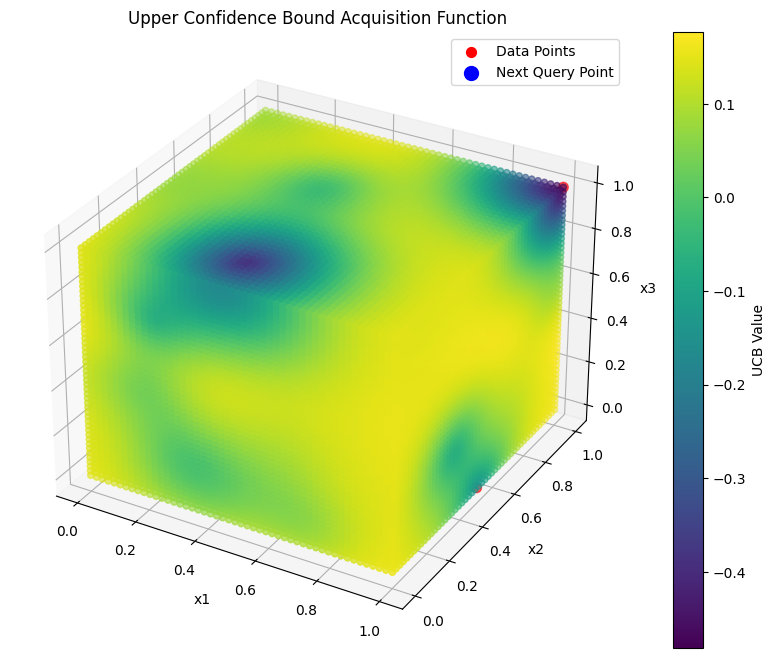

In [13]:
# Plot the acquisition function
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid for 3D plotting
X_mesh, Y_mesh, Z_mesh = np.meshgrid(x1, x2, x3)

# Flatten the mesh grid and UCB for plotting
X_plot = X_mesh.flatten()
Y_plot = Y_mesh.flatten()
Z_plot = Z_mesh.flatten()
UCB_plot = ucb.flatten()

# Plot the UCB values
scatter = ax.scatter(X_plot, Y_plot, Z_plot, c=UCB_plot, cmap='viridis')
fig.colorbar(scatter, ax=ax, label='UCB Value')

# Plot the initial sample points
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='red', s=50, label='Data Points')

# Highlight the next query point
ax.scatter(next_query[0], next_query[1], next_query[2], c='blue', s=100, label='Next Query Point')

ax.set_title('Upper Confidence Bound Acquisition Function')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.legend()
plt.show()


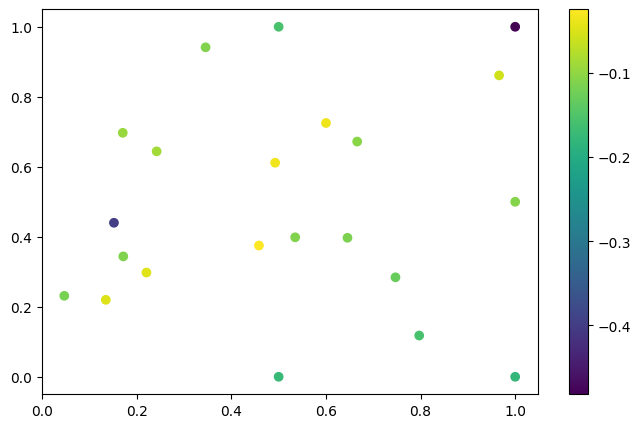

In [14]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.colorbar();

In [15]:
print(f"{str(next_query[0]).ljust(8,'0')[:8]}-{str(next_query[1]).ljust(8,'0')[:8]}-{str(next_query[2]).ljust(8,'0')[:8]}")

0.551020-0.755102-0.653061
